In [1]:
!pip install pandas seaborn

     |████████████████████████████████| 10.0MB 5.5MB/s eta 0:00:01
     |████████████████████████████████| 215kB 97.3MB/s eta 0:00:01
     |████████████████████████████████| 512kB 101.4MB/s eta 0:00:01
     |████████████████████████████████| 25.1MB 101.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers

print(tf.__version__)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [3]:
dataset_path = "ik_6dof.csv"

In [4]:
column_names = ["translation_x", "translation_y", "translation_z", "theta1", "theta2", "theta3",
                "theta4", "theta5", "theta6"]
raw_dataset = pd.read_csv(dataset_path,
                          names=column_names,
                          na_values="?",
                          sep=",",
                          skipinitialspace=True)

dataset = raw_dataset.copy()
print(dataset.tail())

print(dataset.isna().sum())
dataset = dataset.dropna()

        translation_x  translation_y  translation_z      theta1      theta2  \
999995      90.600709       3.130734    -177.565373   24.750391 -168.296679   
999996      64.236788    -103.948842    -191.215380  111.443167  125.984113   
999997     -18.087501    -100.833503      24.598683   71.934555    1.193925   
999998     161.835885      41.618081      57.099459   22.046046  -66.172648   
999999      -1.858173      25.420049      76.247941   83.019491 -152.445475   

            theta3      theta4      theta5      theta6  
999995  -38.687057  156.859558   66.539721  105.601070  
999996  -64.989975   65.660977  -49.109280   19.674842  
999997 -152.220614  159.501757  179.821523   76.082812  
999998    2.371009   53.628884 -146.557253  -71.328159  
999999 -158.605395  163.696069  -52.099780   97.884625  
translation_x    0
translation_y    0
translation_z    0
theta1           0
theta2           0
theta3           0
theta4           0
theta5           0
theta6           0
dtype: int64

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
train_labels = train_dataset[["theta1", "theta2", "theta3", "theta4", "theta5", "theta6"]]
test_dataset = dataset.drop(train_dataset.index)
test_labels = test_dataset[["theta1", "theta2", "theta3", "theta4", "theta5", "theta6"]]

In [6]:
model = keras.Sequential([
    layers.Dense(128, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation=tf.nn.tanh),
    layers.Dense(len(train_labels.keys()), activation=tf.keras.activations.linear)
])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy', 'mean_squared_error'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 18,566
Trainable params: 18,566
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
class PrintDot(keras.callbacks.Callback):
    # noinspection PyMethodOverriding
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_dataset,
                    train_labels,
                    epochs=1000,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])
print('')

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
.....


In [10]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
print(history_df.tail())

          acc       loss  mean_squared_error   val_acc   val_loss  \
200  0.917523  98.277971           98.277679  0.916806  99.210787   
201  0.916936  98.360381           98.360657  0.918456  98.176556   
202  0.917522  98.270873           98.270882  0.917219  98.082135   
203  0.917898  97.608637           97.608604  0.918025  98.307269   
204  0.918433  97.932435           97.932152  0.917350  98.633219   

     val_mean_squared_error  epoch  
200               99.210747    200  
201               98.176498    201  
202               98.082153    202  
203               98.307205    203  
204               98.633308    204  


In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label='Val Error')
    plt.semilogy()
    plt.legend()
    plt.show()

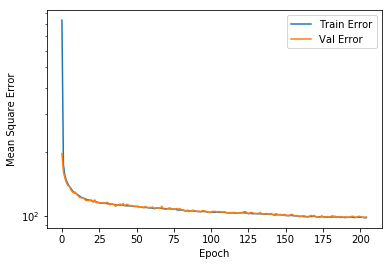

In [12]:
plot_history(history)

In [13]:
loss, accuracy, mse = model.evaluate(test_dataset, test_labels, verbose=0)
print("Test dataset Accuracy: {} Mean Square Error: {}".format(accuracy, mse))

Test dataset Accuracy: 0.917930006980896 Mean Square Error: 98.54605102539062
